In [18]:
df_eda = df
sc.applicationId

'local-1698763673578'

In [19]:
# Show top 30 records
df = df.withColumnRenamed('No.', 'NO')
df = df.withColumn('NO', df['NO'].cast(IntegerType()))
df.show(5,0)

# List of columns to remove from dataset
# cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# # Drop columns in list
# df = df.drop(*cols_to_drop)

+---+-----+-------------------+-----------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+----------+---------+-----------------+-----------------------------+------------+---------------+----------+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------+----------+------------------+---------------+----+--------------------------------------------------------------+---------------+------+----------+---------+------------------+-------+----------+----------+---------+------------------+---------------------------+-----+------------------+-------------------------------------------------------------------------------------+----------------+--------------+---------+------------+----------+----------+---------+----

In [20]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
# df.select(['ASSUMABLEMORTGAGE']).distinct().show()

# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.where(text_filter)

# print count of remaining records
print(df.count())

4976


In [21]:
df.printSchema()

root
 |-- NO: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- StreetNumberNumeric: string (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SALESCLOSEPRICE: double (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: string (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: string (nullable = true)
 |-- PricePerTSFT: string (nullable = true)
 |-- FOUNDATIONSIZE: double (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- LotSizeDimensions: string (nullable = true)
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- DAYSONMARKET: double (nullable = true)
 |-- offmarketdate: string (nullable = true)
 |-- FIREPLACES: double (nullable = true)
 |-- RoomArea4: string (nullable = true)
 |

In [22]:
df = df.withColumn("log_SalesClosePrice", F.log("SALESCLOSEPRICE"))
df.select('log_SalesClosePrice','SALESCLOSEPRICE').show(3,0)

+-------------------+---------------+
|log_SalesClosePrice|SALESCLOSEPRICE|
+-------------------+---------------+
|11.870599909242044 |143000.0       |
|12.154779351142624 |190000.0       |
|12.323855681186558 |225000.0       |
+-------------------+---------------+
only showing top 3 rows



In [23]:
from pyspark.sql.functions import mean, stddev

# Calculate values used for outlier filtering
mean_val = df.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

# Create three standard deviation (n � 3d) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.where((df['log_SalesClosePrice'] < hi_bound) & (df['log_SalesClosePrice'] > low_bound))

In [24]:
df[['DAYSONMARKET']].printSchema()


root
 |-- DAYSONMARKET: double (nullable = true)



In [25]:
# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn(
    'percentage_scaled_days', 
    F.round((df['DAYSONMARKET'] - float(min_days)) / (float(max_days) - float(min_days))) * 100
)

# Calc max and min for new column
print(df.agg({'percentage_scaled_days': 'max'}).collect())
print(df.agg({'percentage_scaled_days': 'min'}).collect())

[Row(max(percentage_scaled_days)=100.0)]
[Row(min(percentage_scaled_days)=0.0)]


In [26]:
def min_max_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_days = df.agg({col: 'max'}).collect()[0][0]
        min_days = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(
            new_column_name, 
            (df[col] - min_days) / (max_days - min_days)
        )
    return df

df = min_max_scaler(df, ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES'])
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show(5,0)

+------------+--------------------+
|DAYSONMARKET|scaled_DAYSONMARKET |
+------------+--------------------+
|10.0        |0.044444444444444446|
|4.0         |0.017777777777777778|
|28.0        |0.12444444444444444 |
|19.0        |0.08444444444444445 |
|21.0        |0.09333333333333334 |
+------------+--------------------+
only showing top 5 rows



In [27]:
from pyspark.sql.functions import log

# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.25317374723020336)]


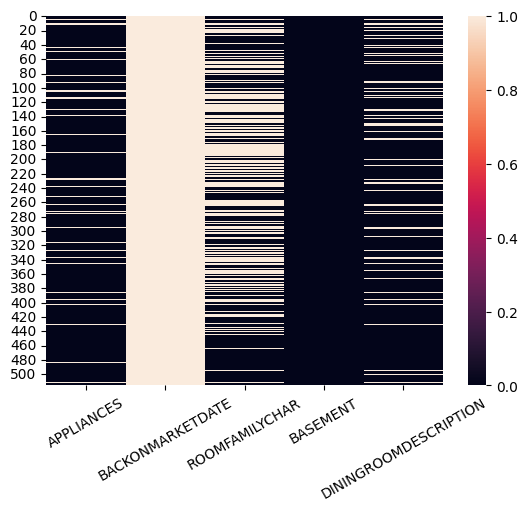

In [28]:
# Sample the dataframe and convert to Pandas
sample_df = df\
    .select(['APPLIANCES',
 'BACKONMARKETDATE',
 'ROOMFAMILYCHAR',
 'BASEMENT',
 'DININGROOMDESCRIPTION'])\
    .sample(False, 0.1, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()


# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

# Set the answer to the column with the most missing data
answer = 'BACKONMARKETDATE'

In [29]:
# Count missing rows
missing = df\
    .where(df['PDOM'].isNull())\
    .count()

# Calculate the mean value
col_mean = df\
    .agg({'PDOM': 'mean'})\
    .collect()[0][0]

print(missing, col_mean)
# Replacing with the mean value for that column
df.fillna(20.792025646163093, subset=['PDOM'])

0 20.762636473918317


DataFrame[NO: int, MLSID: string, StreetNumberNumeric: string, streetaddress: string, STREETNAME: string, PostalCode: string, StateOrProvince: string, City: string, SALESCLOSEPRICE: double, LISTDATE: string, LISTPRICE: string, LISTTYPE: string, OriginalListPrice: string, PricePerTSFT: string, FOUNDATIONSIZE: double, FENCE: string, MapLetter: string, LotSizeDimensions: string, SchoolDistrictNumber: string, DAYSONMARKET: double, offmarketdate: string, FIREPLACES: double, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: double, GarageDescription: string, SQFTABOVEGROUND: double, TAXES: double, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: double, LIVINGAREA: double, UNITNUMBER: string, YEARBUILT: double, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, BACKONMARKETDATE: double, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: strin

In [30]:
df_berfore_postal = df

In [31]:

# Create a dictionary with PostalCode as key and latitude and longitude as values
postal_code_lat_long = {
    55125: ('44.88482', '-92.88453'),
    55101: ('44.94669', '-93.09082'),
    55114: ('44.97199', '-93.18678'),
    55102: ('44.93124', '-93.09261'),
    55106: ('44.95407', '-93.04886'),
    55042: ('45.05752', '-92.83653'),
    55117: ('45.02122', '-93.11411'),
    55103: ('44.95934', '-93.12318'),
    55108: ('44.98207', '-93.16830'),
    55118: ('44.89155', '-93.06442'),
    55104: ('44.95127', '-93.18977'),
    55105: ('44.93867', '-93.16896'),
    55109: ('45.01439', '-92.98510'),
    55116: ('44.91203', '-93.17243'),
    55129: ('44.86122', '-92.90367'),
    55107: ('44.95587', '-93.10288'),
    55128: ('44.92611', '-92.99849'),
    55119: ('44.95898', '-93.01125'),
    55130: ('44.95886', '-92.98013'),
    55113: ('45.00603', '-93.14384')
}
# Convert dictionary to DataFrame
lat_long_df = spark.createDataFrame(
    [(int(k), v[0], v[1]) for k, v in postal_code_lat_long.items()],
    ['PostalCode', 'Latitude', 'Longitude']
)

# Join the two DataFrames on PostalCode column
df = df.join(lat_long_df, ['PostalCode'])
df.printSchema()

root
 |-- PostalCode: string (nullable = true)
 |-- NO: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- StreetNumberNumeric: string (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SALESCLOSEPRICE: double (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: string (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: string (nullable = true)
 |-- PricePerTSFT: string (nullable = true)
 |-- FOUNDATIONSIZE: double (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- LotSizeDimensions: string (nullable = true)
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- DAYSONMARKET: double (nullable = true)
 |-- offmarketdate: string (nullable = true)
 |-- FIREPLACES: double (nullable = true)
 |-- RoomArea4: string (nullable = true)
 |

In [32]:
df.select('PostalCode', 'Latitude', 'Longitude').show(5,0)

+----------+--------+---------+
|PostalCode|Latitude|Longitude|
+----------+--------+---------+
|55125     |44.88482|-92.88453|
|55125     |44.88482|-92.88453|
|55125     |44.88482|-92.88453|
|55125     |44.88482|-92.88453|
|55125     |44.88482|-92.88453|
+----------+--------+---------+
only showing top 5 rows



In [33]:
df = df.withColumn('Latitude', df['Latitude'].cast('double'))\
    .withColumn('Longitude', df['Longitude'].cast('double'))

In [34]:
df_after_postal = df

In [35]:
walk_df = spark.read.csv('./tmp_walk_m_20.csv', header=True, inferSchema=True)
walk_df.show(5,0)
walk_df.printSchema()
walk_df.dropDuplicates().count()

+--------+---------+---------+---------+------------+
|latitude|longitude|walkscore|bikescore|transitscore|
+--------+---------+---------+---------+------------+
|44.88482|-92.88453|69       |26       |68          |
|44.94669|-93.09082|2        |58       |53          |
|44.97199|-93.18678|27       |79       |73          |
|44.93124|-93.09261|35       |81       |8           |
|44.95407|-93.04886|87       |35       |9           |
+--------+---------+---------+---------+------------+
only showing top 5 rows

root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- walkscore: integer (nullable = true)
 |-- bikescore: integer (nullable = true)
 |-- transitscore: integer (nullable = true)



20

In [36]:
df_before_walk = df

In [37]:
# Cast data types
walk_df = walk_df\
    .withColumn('longitude_walk', walk_df['longitude'].cast('double'))\
    .withColumn('latitude_walk', walk_df['latitude'].cast('double'))\
    .drop('longitude', 'latitude')

# Round precision
df = df.withColumn('latitude', F.round('latitude', 5))
df = df.withColumn('longitude', F.round('longitude', 5))

# Create join condition
condition = [
    walk_df['latitude_walk'] == df['latitude'],
    walk_df['longitude_walk'] == df['longitude']
]

# Join the dataframes together
join_df = df.join(walk_df, on=condition, how='left')
join_df.drop('longitude_walk', 'latitude_walk')
# Count non-null records from new field
# print(join_df.where(~join_df['walkscore'].isNull()).count()) # 4946
join_df.printSchema()

root
 |-- PostalCode: string (nullable = true)
 |-- NO: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- StreetNumberNumeric: string (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SALESCLOSEPRICE: double (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: string (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: string (nullable = true)
 |-- PricePerTSFT: string (nullable = true)
 |-- FOUNDATIONSIZE: double (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- LotSizeDimensions: string (nullable = true)
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- DAYSONMARKET: double (nullable = true)
 |-- offmarketdate: string (nullable = true)
 |-- FIREPLACES: double (nullable = true)
 |-- RoomArea4: string (nullable = true)
 |

In [38]:
join_df = join_df.drop('longitude_walk', 'latitude_walk')
join_df.show(5,0)
join_df.count()

+----------+----+-----+-------------------+-------------------+-----------+---------------+-------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+-------+---------+-----------------+-----------------------------+------------+--------------+----------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------+----------+------------------+---------------+----+--------------------------------------------------------------------------+---------------+-------+----------+---------+------------------+-------+----------+----------+---------+------------------+----------------+-----+------------------+----------------------------------------------------------------------------------------------------------------------------

4946

In [39]:
df_after_walk = df

In [40]:
# Register dataframes as tables
df.createOrReplaceTempView("df")
walk_df.createOrReplaceTempView("walk_df")

# SQL to join dataframes
join_sql = 	"""
			SELECT 
				*
			FROM df
			LEFT JOIN walk_df
			ON df.longitude = walk_df.longitude_walk
			AND df.latitude = walk_df.latitude_walk
			"""
# Perform sql join
joined_df = spark.sql(join_sql)
join_df.show(5,0)
join_df.count()

+----------+----+-----+-------------------+-------------------+-----------+---------------+-------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+-------+---------+-----------------+-----------------------------+------------+--------------+----------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------+----------+------------------+---------------+----+--------------------------------------------------------------------------+---------------+-------+----------+---------+------------------+-------+----------+----------+---------+------------------+----------------+-----+------------------+----------------------------------------------------------------------------------------------------------------------------

4946

In [41]:
df_orig  = join_df

In [42]:
correct_join_df = join_df

In [43]:
correct_join_df.printSchema ()

root
 |-- PostalCode: string (nullable = true)
 |-- NO: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- StreetNumberNumeric: string (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SALESCLOSEPRICE: double (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: string (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: string (nullable = true)
 |-- PricePerTSFT: string (nullable = true)
 |-- FOUNDATIONSIZE: double (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- LotSizeDimensions: string (nullable = true)
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- DAYSONMARKET: double (nullable = true)
 |-- offmarketdate: string (nullable = true)
 |-- FIREPLACES: double (nullable = true)
 |-- RoomArea4: string (nullable = true)
 |

In [44]:
wrong_prec_df = join_df

In [45]:
# # Join on mismatched keys precision 
# wrong_prec_cond = [
# 	df_orig.longitude == walk_df.longitude_walk,
# 	df_orig.latitude == walk_df.latitude_walk
# ]
# # wrong_prec_df = df_orig.join(walk_df, on=wrong_prec_cond, how='left')
# wrong_prec_df = df_orig.join(walk_df, on=wrong_prec_cond, how='left')

# Compare bad join to the correct one
print(
	wrong_prec_df\
		.where(wrong_prec_df['walkscore'].isNull())\
		.count()
)
print(
	correct_join_df\
		.where(correct_join_df['walkscore'].isNull())\
		.count()
)
print("Record Count of the Correct Join Example: " + str(correct_join_df.count()))


0
0
Record Count of the Correct Join Example: 4946


In [46]:


# Create a join on too few keys
few_keys_cond = [df['longitude'] == walk_df['longitude_walk']]
few_keys_df = df.join(walk_df, on=few_keys_cond, how='left')

# Compare bad join to the correct one
print("Record Count of the Too Few Keys Join Example: " + str(few_keys_df.count()))

Record Count of the Too Few Keys Join Example: 4946
